# Introduction

Sometimes, I use static tracepoints to get a coarse idea on the time
needed to execute some operation, some function, syscalls, etc. inside
the kernel. However, each time I do that, I am dumb enough to consider
the tracepoint cost as negligible. It is indeed easier to believe that
tracepoints or probes will not modify the dynamic behaviour of what I
am looking for...

Let's be back to reality and test an idea from Brendan Gregg to assess
tracepoint cost.

**Step 1**:

* Find a test case which repeatedly perform the same operation:
  syscalls;
```
$ dd if=/dev/zero of=/dev/null bs=1 count=3000000
```
* Measure the execution times of this command with and without
  syscall-related tracepoints (or probes);
* The comparison of the execution times will give us the
  tracepoints/probes overhead;
* Repeat the test above with dynamic probes instead of static
  tracepoints.

**Step 2**:

* (Basically) profile tracepoint-related operations (tracepoint code
  execution, tracepoint recording into the ring buffer, etc.)...
* ...and find out which part is the most expensive.


# Description of the test environments

In this document, the tests will be executed in 2 enviromnents.

*First environment: real (laptop) machine*

* CPU: Intel Core i7-3537U @ 2.00GHz (up to 3.10GHz) 1 CPU / 2 cores
  per CPU / 2 threads per core;
* RAM: 8GB;
* System: Arch (glibc-2.23)
* Cpufreq governor: performance: the pstate power scaling driver is
  used; so the CPU frequency cannot be statically set with a
  user-space tool.
```
# cpupower frequency-set -g performance
```

*Second environment: Qemu/kvm guest*

* Qemu/kvm virtual machine running on 2 cores of the CPU above;
* RAM: 3GB;
* System: buildroot generated (glibc- 2.22).

The first environment and, mechanically, the second one have many accuracy flaws:

* With this Ivy Bridge processor, the time-stamp counter cannot be
  used to measure time in cycles; the CPU displays the flag
  "constant_tsc"; so, the TSC frequency is stable unlike with the
  on-demand adapted CPU frequency, the TSC cycles are not correlated
  with the CPU cycles anymore.
* The pstate power scaling driver does not enable user-space
  applications to set a constant CPU frequency.


The following workaround should be tested:
```
Kernel command line: ... intel_pstate=disable
Other CPUfreq driver to use: acpi-cpufreq
Other governor to use: userspace
Set a constant frequency value: cpupower frequency-set -f 2GHz
```

# Step 1: assess the overhead of a static tracepoint (and a dynamic probe)

We need to find a dd-based test:

* Long enough to be sure the measured execution times are significant
  (at least many tens of milliseconds) when tracepoints are disabled;
* Short enough not to generate a too big perf output archive.

The command line below will execute 3 millions of read syscalls + 3
millions of write syscalls:
````
$ time dd if=/dev/zero of=/dev/null bs=1 count=3000000
````


## Results without tracepoints

```
$ time dd if=/dev/zero of=/dev/null bs=1 count=3000000
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 0.616568 s, 4.9 MB/s

real    0m0.617s
user    0m0.173s
sys     0m0.443s
```

The test above allowed us to calculate the cost of the syscalls read
/ write:

* Let's consider that time spent in user space corresponds only to
  time needed to initiate the syscalls...
* ...so, we consider that the cost of all syscalls is the user time +
  the system time.

Here is the estimated cost of the syscalls:
  
````
(0.173s + 0.443s) / 6000000 syscalls = 103ns
time cost per syscall = 103ns
````

So, for the first configuration, the average execution time of a
syscall (executed in loop, so maybe without instruction cache miss)
seems to reach 103ns.

## Results with the static tracepoint raw_syscalls:sys_enter enabled

Here is the format of the tracepoint "raw_syscalls:sys_enter"; there
are 7 additional serialized fields (associated to the "common" fields).

````
# cat /sys/kernel/debug/tracing/events/raw_syscalls/sys_enter/format
name: sys_enter
ID: 17
format:
field:unsigned short common_type;       offset:0;       size:2; signed:0;
field:unsigned char common_flags;       offset:2;       size:1; signed:0;
field:unsigned char common_preempt_count;       offset:3;       size:1; signed:0;
field:int common_pid;   offset:4;       size:4; signed:1;

field:long id;  offset:8;       size:8; signed:1;
field:unsigned long args[6];    offset:16;      size:48;        signed:0;

print fmt: "NR %ld (%lx, %lx, %lx, %lx, %lx, %lx)", REC->id, REC->args[0], REC->args[1], REC->args[2], REC->args[3], REC->args[4], REC->args[5]
````

Here is the test:

````
# perf record -e raw_syscalls:sys_enter -- bash -c "time dd if=/dev/zero of=/dev/null bs=1 count=3000000"
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 2.72848 s, 1.1 MB/s

real    0m2.729s
user    0m0.173s
sys     0m2.553s
[ perf record: Woken up 149 times to write data ]
[ perf record: Captured and wrote 695.266 MB perf.data (6000249 samples) ]
````

Here is the estimated cost of the static tracepoint raw_syscalls:sys_enter:

````
(0.173s + 2.553s) / 6000000 syscalls = 454ns
time cost per static tracepoint sys_enter = 454ns - 103ns = 351ns
````

## Results with the static tracepoints syscalls:sys_enter_read and syscalls:sys_enter_write enabled

Here are the format of the tracepoints; there are 4 additional
serialized fields (instead of 7 above).

````
# cat /sys/kernel/debug/tracing/events/syscalls/sys_enter_read/format
name: sys_enter_read
ID: 533
format:
field:unsigned short common_type;       offset:0;       size:2; signed:0;
field:unsigned char common_flags;       offset:2;       size:1; signed:0;
field:unsigned char common_preempt_count;       offset:3;       size:1; signed:0;
field:int common_pid;   offset:4;       size:4; signed:1;

field:int nr;   offset:8;       size:4; signed:1;
field:unsigned int fd;  offset:16;      size:8; signed:0;
field:char * buf;       offset:24;      size:8; signed:0;
field:size_t count;     offset:32;      size:8; signed:0;

print fmt: "fd: 0x%08lx, buf: 0x%08lx, count: 0x%08lx", ((unsigned long)(REC->fd)), ((unsigned long)(REC->buf)), ((unsigned long)(REC->count))


# cat /sys/kernel/debug/tracing/events/syscalls/sys_enter_write/format
name: sys_enter_write
ID: 531
format:
field:unsigned short common_type;       offset:0;       size:2; signed:0;
field:unsigned char common_flags;       offset:2;       size:1; signed:0;
field:unsigned char common_preempt_count;       offset:3;       size:1; signed:0;
field:int common_pid;   offset:4;       size:4; signed:1;

field:int nr;   offset:8;       size:4; signed:1;
field:unsigned int fd;  offset:16;      size:8; signed:0;
field:const char * buf; offset:24;      size:8; signed:0;
field:size_t count;     offset:32;      size:8; signed:0;

print fmt: "fd: 0x%08lx, buf: 0x%08lx, count: 0x%08lx", ((unsigned long)(REC->fd)), ((unsigned long)(REC->buf)), ((unsigned long)(REC->count))
````

Here is the test:

````
# perf record -e syscalls:sys_enter_read -e syscalls:sys_enter_write -- bash -c "time dd if=/dev/zero of=/dev/null bs=1 count=3000000"
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 2.75248 s, 1.1 MB/s

real    0m2.753s
user    0m0.207s
sys     0m2.543s
[ perf record: Woken up 76 times to write data ]
[ perf record: Captured and wrote 603.976 MB perf.data (6000029 samples) ]
````

Here is the estimated cost of the static tracepoints:

````
(0.207s + 2.543s) / 6000000 syscalls = 458ns
time cost per static tracepoint sys_enter = 458ns - 103ns = 355ns
````

## Results with the dynamic probes probe:sys_read and probe:sys_write enabled

Here are the commands to create and list the dynamic probes:

````
# perf probe --add=sys_read
Added new event:
probe:sys_read       (on sys_read)

You can now use it in all perf tools, such as:

perf record -e probe:sys_read -aR sleep 1

# perf probe --add=sys_write
Added new event:
probe:sys_write      (on sys_write)

You can now use it in all perf tools, such as:

perf record -e probe:sys_write -aR sleep 1

# perf probe --list
probe:sys_read       (on SyS_read)
probe:sys_write      (on SyS_write)

````

Here is the test:

````
# perf record -e probe:sys_read -e probe:sys_write -- bash -c "time dd if=/dev/zero of=/dev/null bs=1 count=3000000"
3000000+0 records in
3000000+0 records out
3000000 bytes (3.0 MB, 2.9 MiB) copied, 3.0314 s, 990 kB/s

real    0m3.032s
user    0m0.287s
sys     0m2.743s
[ perf record: Woken up 87 times to write data ]
[ perf record: Captured and wrote 467.574 MB perf.data (6000029 samples) ]
````

Here is the estimated cost of the dynamic probes:

````
(0.287s + 2.743s) / 6000000 syscalls = 505ns
time cost per dynamic probe = 505ns - 103ns = 402ns
````

## Interpretation

On a Ivybridge core i7 running at up to 3.1GHz:

* The average execution time of syscalls read / write is 103ns;
* The average cost of the static tracepoint raw_syscalls:sys_enter
  (with its 7 additional arguments) is 351ns;
* The average cost of the static tracepoints syscalls:sys_enter_write
  and syscalls:sys_enter_read is 355ns (each with 4 additional
  arguments); 
* The average cost of the dynamic probes probe:sys_write and
  probe:sys_read is 402ns;

So, with the small tests above:

* It was impossible to prove that additional arguments of a tracepoint
  are a great part of the global cost.
* We might conclude that dynamic probes are slightly more expensive
  than static tracepoints 40-50ns.

However, the tests above do not give us any idea on the noise, the
distribution of the values; maybe, 90% of the tracepoints cost 100ns
and the left 10% far more; so, let's use the recorded perf archives to
extract some basic statistics thanks to Pandas; it might help us find
out whether the tests performed in this first part are relevant.

# Some basic statistics extracted from perf archives

The python package linux-perf-stats provides 2 python scripts to be
executed by perf: export-to-csv.py and export-to-hdfstore.py. Both
provides the same feature: serialize the perf events into a Pandas
Dataframe compatible format.

Here, we have used export-to-hdfstore.py:

```
# perf script -s ~/workspace/perf/linux-perf-stats/share/perf_python_scripts/export-to-hdfstore.py -i kprobe_syscalls_read_write.data output=kprobe_syscalls_read_write.h5
# perf script -s ~/workspace/perf/linux-perf-stats/share/perf_python_scripts/export-to-hdfstore.py -i raw_syscalls_sys_enter.data output=raw_syscalls_sys_enter.h5
# perf script -s ~/workspace/perf/linux-perf-stats/share/perf_python_scripts/export-to-hdfstore.py -i syscalls_read_write.data output=syscalls_read_write.h5
```

We will reload each of the files above into Pandas DataFrames; thanks
to the small module linux-perf-stats, the dataframes will be processed
so as to get some statistics. Thus, we will be able to find out
whether the average cost values calculated in the former chapter are
relevant.

## Pre-requisite python import code

In [25]:
import pandas as pd
import linux_perf_stats as lps

%matplotlib inline
lps.configure_plots()

-c:5: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.



## Statistics for the case: static tracepoint raw_syscalls:sys_enter

In [48]:
fname = '/home/alexis/workspace/perf/test_dd/raw_syscalls_sys_enter.h5'

# Read the DataFrame
store = pd.HDFStore(fname, mode='r')
df = store['events']
del store

# Check there is only one process recorded...
print 'Different recorded processes: ', df.comm.unique()
# ...no; I forgot bash; let's keep only 'dd' events
df = df.loc[df.comm == 'dd']

Different recorded processes:  ['bash' 'dd']


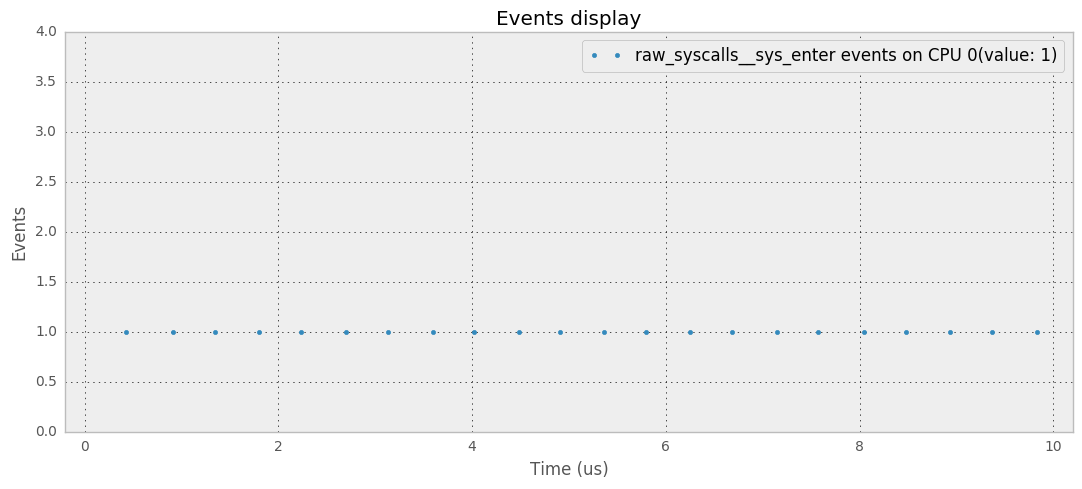

In [49]:
lps.plot_event_timeline(df, offset='1ms', delay='10us')

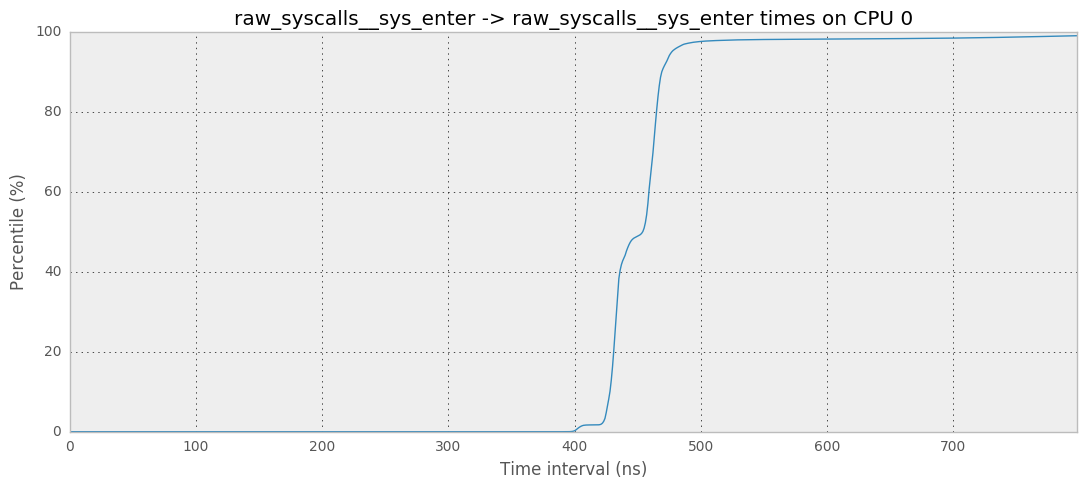

In [9]:
lps.plot_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter')

In [17]:
lps.print_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter')

count    6.000056e+06
mean     4.583898e+02
std      4.050435e+02
min      0.000000e+00
25%      4.330000e+02
50%      4.540000e+02
75%      4.640000e+02
max      1.018870e+05
Name: duration, dtype: float64


Time interval statistics from raw_syscalls__sys_enter to raw_syscalls__sys_enter :
CPU 0


## Statistics for the case: static tracepoints syscalls:sys_enter_read and syscalls:sys_enter_write

In [44]:
fname = '/home/alexis/workspace/perf/test_dd/syscalls_read_write.h5'

# Read the DataFrame
store = pd.HDFStore(fname, mode='r')
df = store['events']
del store

# Check there is only one process recorded...
print 'Different recorded processes: ', df.comm.unique()
# ...no; I forgot bash; let's keep only 'dd' events
df = df.loc[df.comm == 'dd']

Different recorded processes:  ['bash' 'dd']


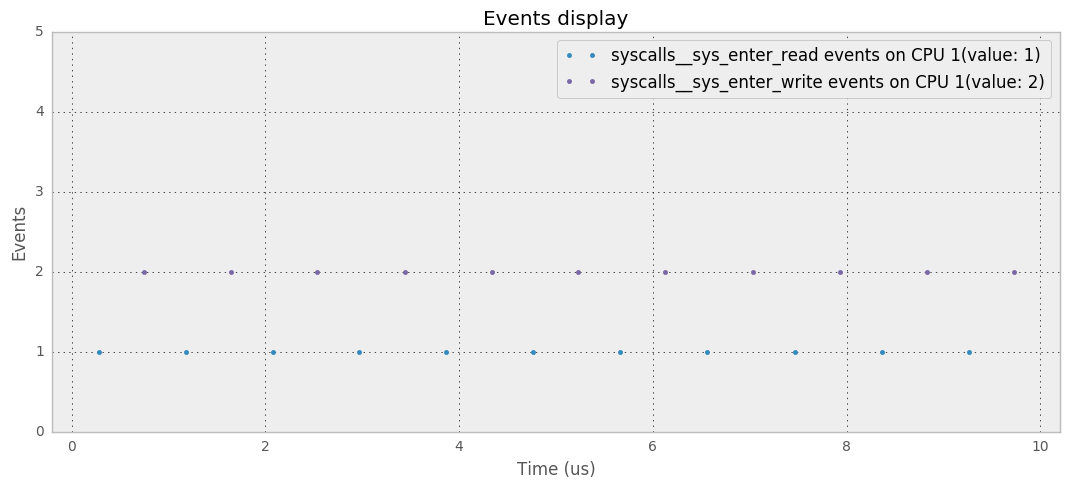

In [45]:
lps.plot_event_timeline(df, offset='1ms', delay='10us')

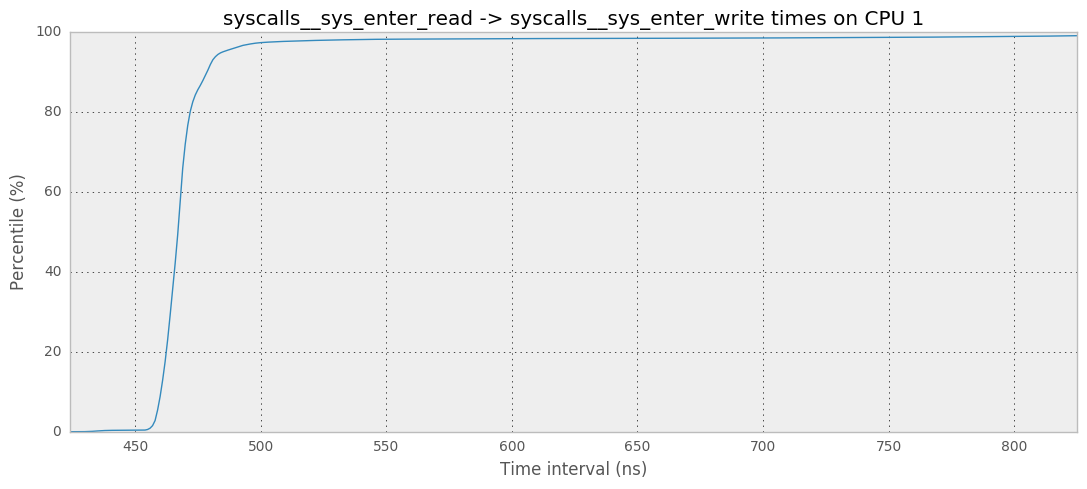

In [30]:
lps.plot_event_intervals(df, 'syscalls__sys_enter_read', 'syscalls__sys_enter_write', cpu=1)

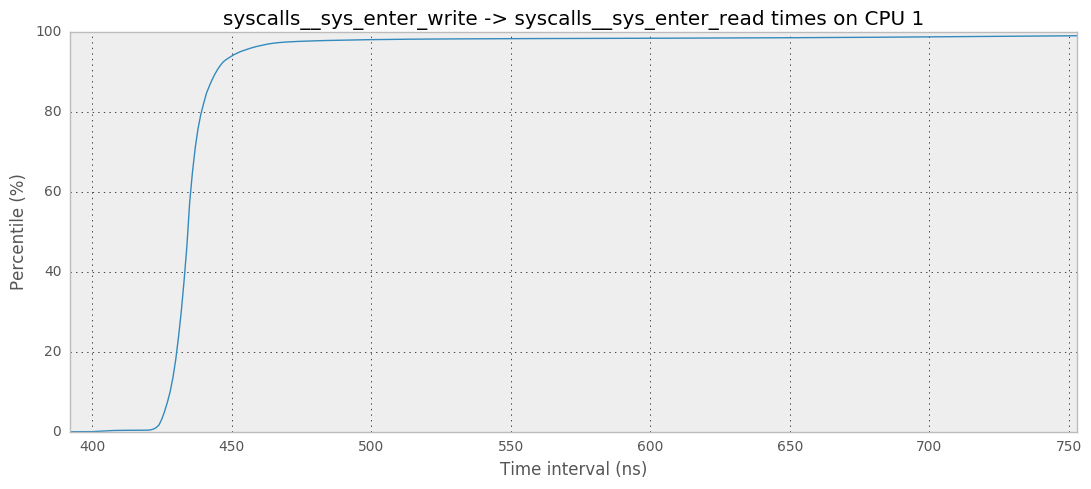

In [33]:
lps.plot_event_intervals(df, 'syscalls__sys_enter_write', 'syscalls__sys_enter_read', cpu=1)

In [34]:
lps.print_event_intervals(df, 'syscalls__sys_enter_read', 'syscalls__sys_enter_write')
lps.print_event_intervals(df, 'syscalls__sys_enter_write', 'syscalls__sys_enter_read')

count    3.000000e+06
mean     4.419535e+02
std      7.589572e+01
min      3.920000e+02
25%      4.320000e+02
50%      4.350000e+02
75%      4.380000e+02
max      5.396900e+04
Name: duration, dtype: float64


count    3.000001e+06
mean     4.755591e+02
std      7.632104e+01
min      4.240000e+02
25%      4.640000e+02
50%      4.680000e+02
75%      4.710000e+02
max      3.285000e+04
Name: duration, dtype: float64
Time interval statistics from syscalls__sys_enter_write to syscalls__sys_enter_read :
CPU 1


Time interval statistics from syscalls__sys_enter_read to syscalls__sys_enter_write :
CPU 1


## Statistics for the case: dynamic probes probe:sys_read and probe:sys_write

In [46]:
fname = '/home/alexis/workspace/perf/test_dd/kprobe_syscalls_read_write.h5'

# Read the DataFrame
store = pd.HDFStore(fname, mode='r')
df = store['events']
del store

# Check there is only one process recorded...
print 'Different recorded processes: ', df.comm.unique()
# ...no; I forgot bash; let's keep only 'dd' events
df = df.loc[df.comm == 'dd']

Different recorded processes:  ['bash' 'dd']


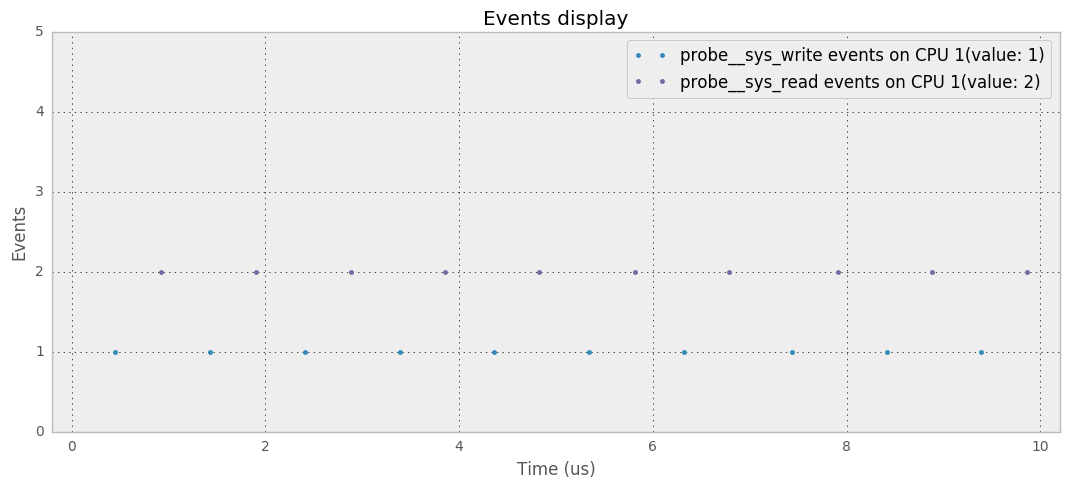

In [47]:
lps.plot_event_timeline(df, offset='1ms', delay='10us')

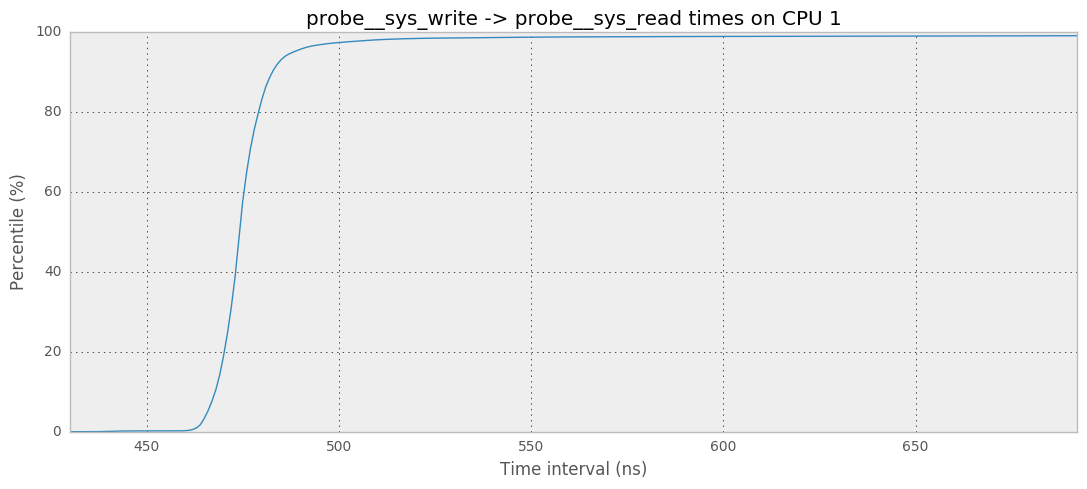

In [39]:
lps.plot_event_intervals(df, 'probe__sys_write', 'probe__sys_read', cpu=1)

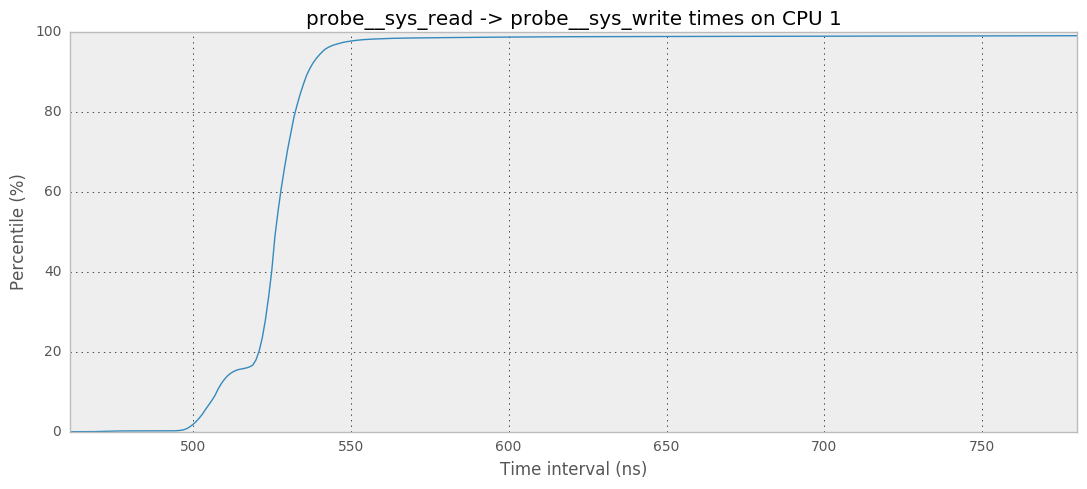

In [40]:
lps.plot_event_intervals(df, 'probe__sys_read', 'probe__sys_write', cpu=1)

In [41]:
lps.print_event_intervals(df, 'probe__sys_write', 'probe__sys_read')
lps.print_event_intervals(df, 'probe__sys_read', 'probe__sys_write')

count    3.000001e+06
mean     5.305638e+02
std      6.703581e+01
min      4.610000e+02
25%      5.230000e+02
50%      5.270000e+02
75%      5.320000e+02
max      3.267200e+04
Name: duration, dtype: float64


count    3.000000e+06
mean     4.799251e+02
std      6.399212e+01
min      4.300000e+02
25%      4.720000e+02
50%      4.750000e+02
75%      4.780000e+02
max      4.356100e+04
Name: duration, dtype: float64
Time interval statistics from probe__sys_read to probe__sys_write :
CPU 1


Time interval statistics from probe__sys_write to probe__sys_read :
CPU 1


## Interpretation

TODO